<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Hesam Hosseini
### Student ID: 400101034

# Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:01<00:00, 6255919.89it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 111031800.02it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 59499728.11it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 2595439.89it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Visualization

In [4]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

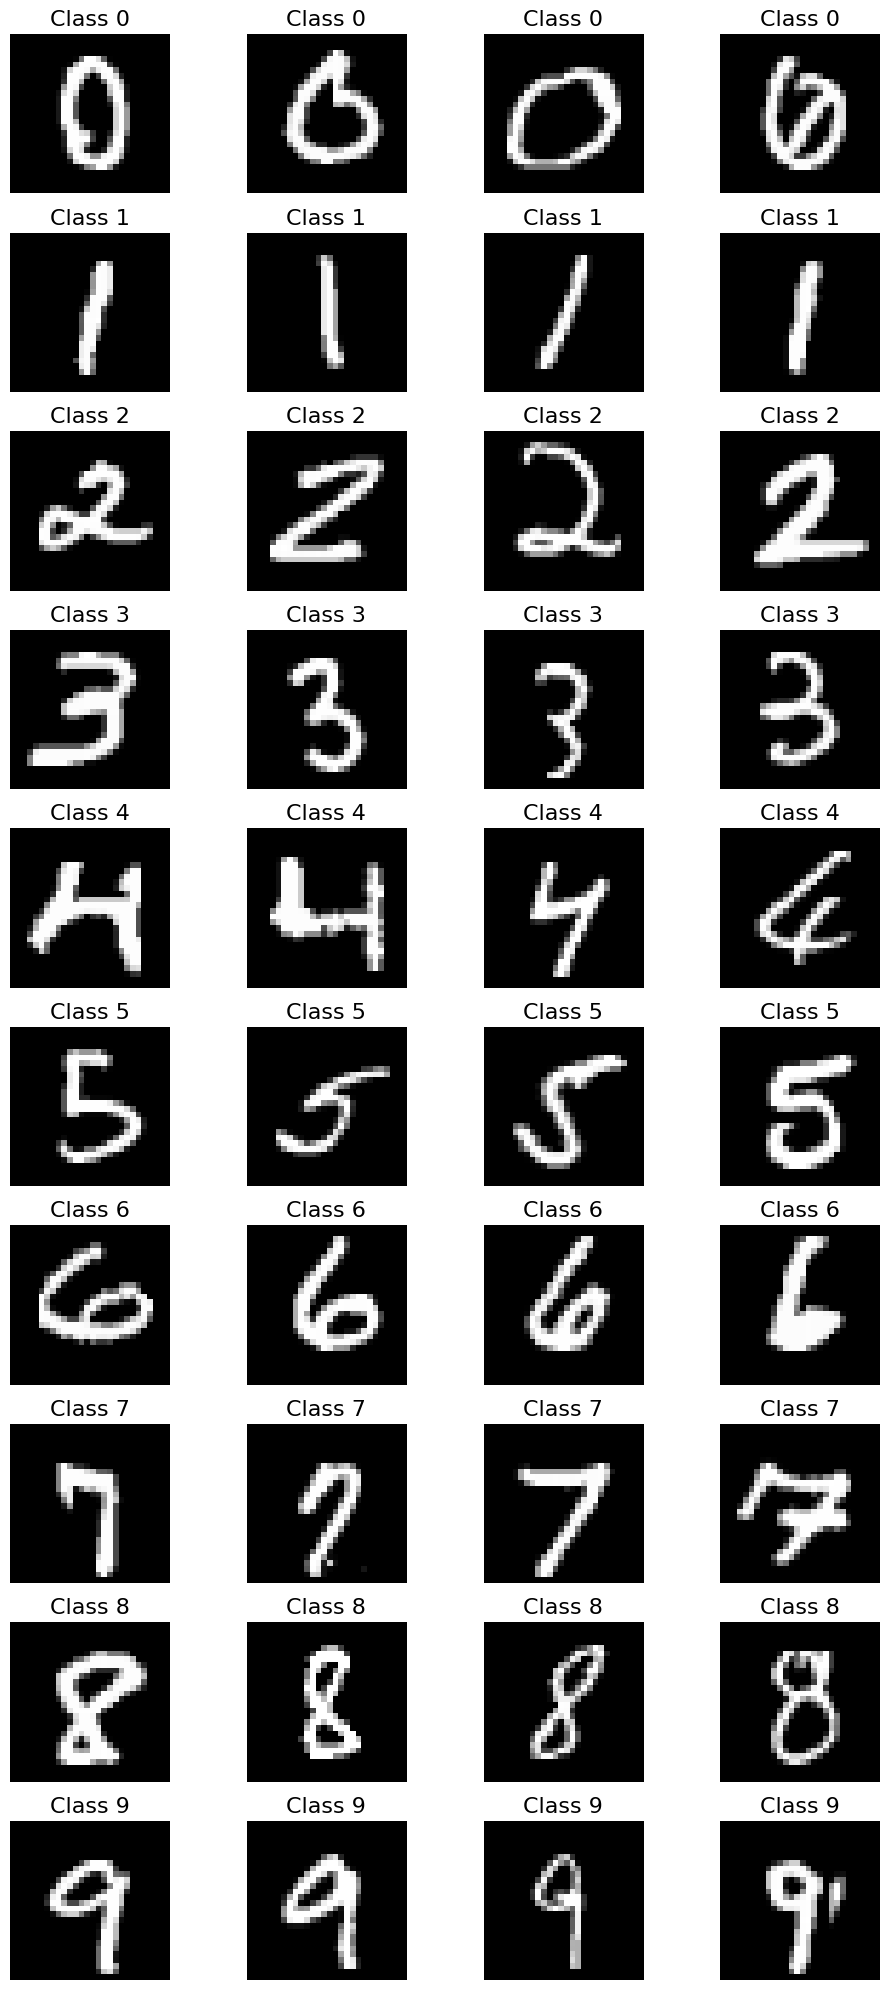

In [5]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP)

Let's get started!

# 1) VAE --> MLP

In [6]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder and decoder
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            # TODO: Add layers for the encoder
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        # TODO: Implement the forward pass
         # Encoder
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        # Reparameterization
        z = self.reparameterize(mu, logvar)

        # Decoder
        x_recon = self.decoder(z)

        return x_recon, mu, logvar,z

In [7]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    # TODO: Implement the reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')
    # reconstruction_loss = nn.BCELoss(reduction='sum')(recon, data)

    # TODO: Implement the KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Return the total loss as the sum of reconstruction and KL divergence losses
    total_loss = reconstruction_loss + kl_divergence
    return total_loss

In [8]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # TODO: Forward process
            optimizer.zero_grad()

            # TODO: Flatten the data and recon tensors
            data = data.view(data.size(0), -1)
            recon, mu, logvar,_ = model(data)

            # TODO: Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()
            total_loss += loss.item()


        avg_loss = total_loss / len(train_loader.dataset)

        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # TODO: Save the best model to a file
    torch.save(best_model, '/content/drive/MyDrive/best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################
VAE-MLP Epoch [1/10], Loss: 184.02406416829427
Sample Images:


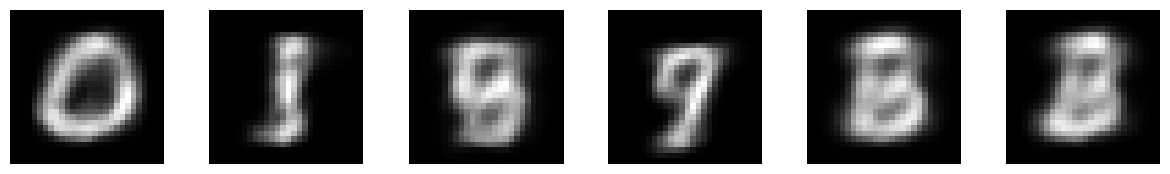


##################################################
VAE-MLP Epoch [2/10], Loss: 163.63648151041667
Sample Images:


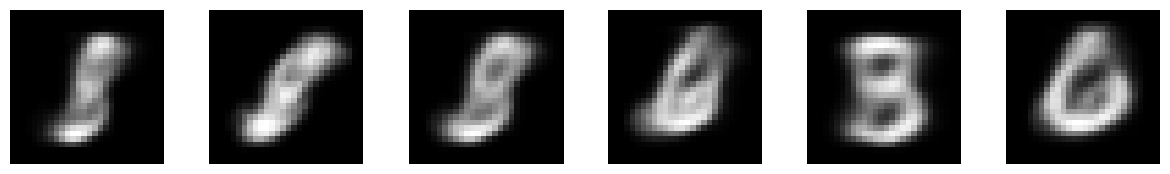


##################################################
VAE-MLP Epoch [3/10], Loss: 159.3072650390625
Sample Images:


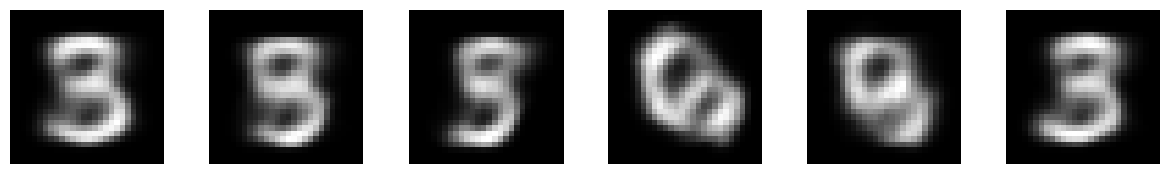


##################################################
VAE-MLP Epoch [4/10], Loss: 156.4794658203125
Sample Images:


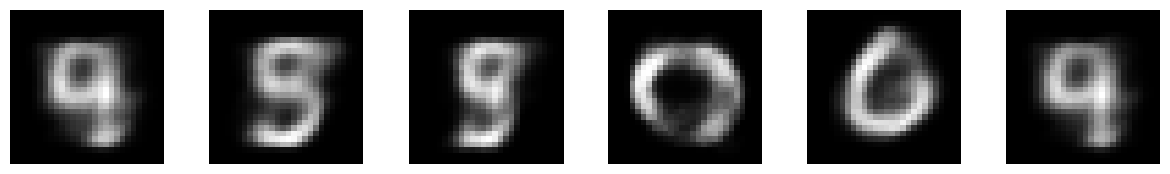


##################################################
VAE-MLP Epoch [5/10], Loss: 154.4926635579427
Sample Images:


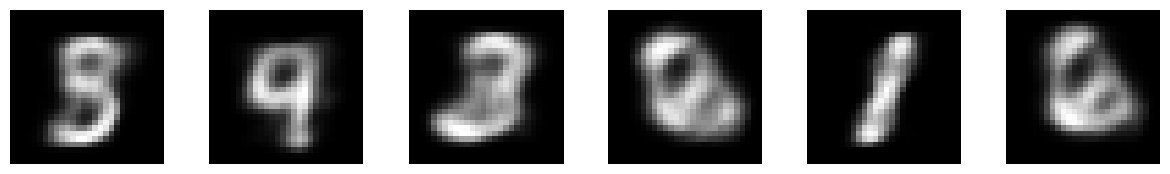


##################################################
VAE-MLP Epoch [6/10], Loss: 153.08377201334636
Sample Images:


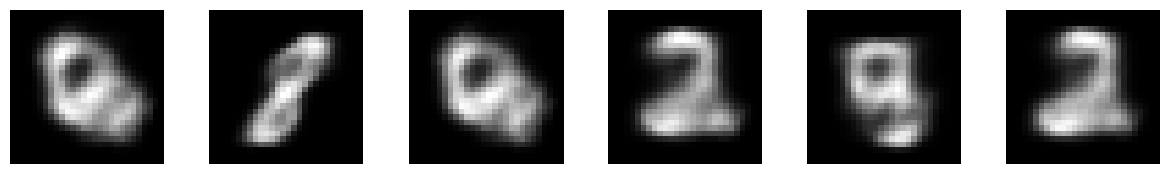


##################################################
VAE-MLP Epoch [7/10], Loss: 152.07786528320312
Sample Images:


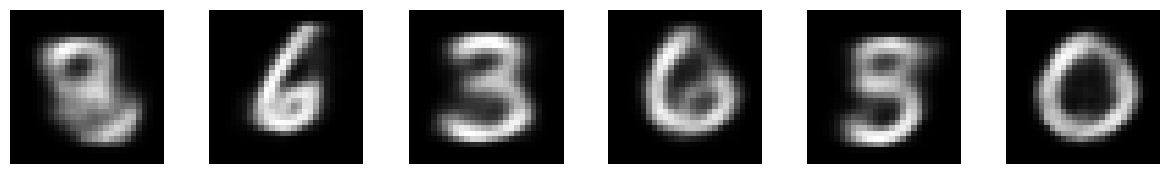


##################################################
VAE-MLP Epoch [8/10], Loss: 151.1870666015625
Sample Images:


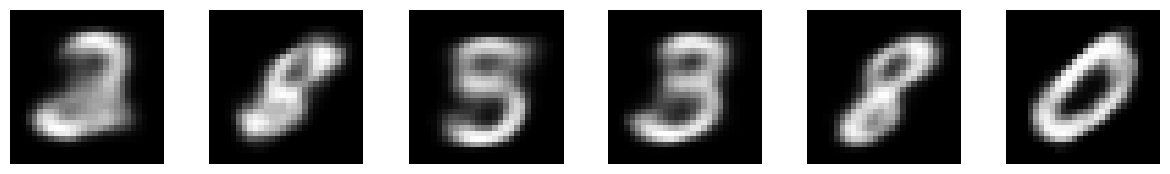


##################################################
VAE-MLP Epoch [9/10], Loss: 150.5952957845052
Sample Images:


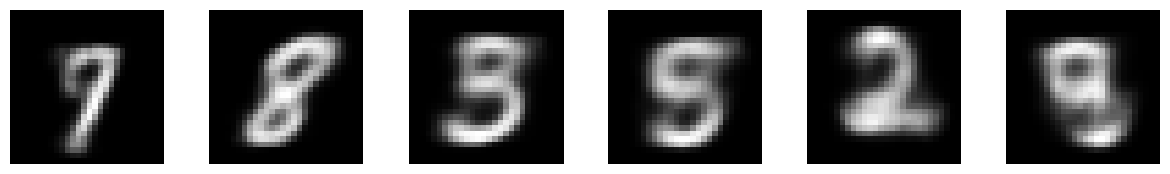


##################################################
VAE-MLP Epoch [10/10], Loss: 149.97650537109374
Sample Images:


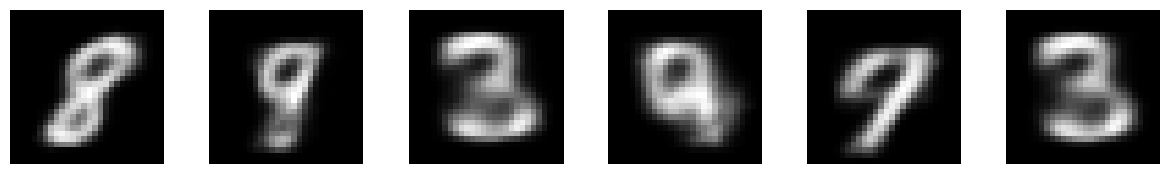

Best model saved as 'best_vae_mlp_model.pth'


In [9]:
# Train VAE-MLP
vae_mlp = VAE_MLP(input_dim=784, hidden_dim=256, latent_dim=2)
train_vae_mlp(vae_mlp, train_loader)

# 2) CVAE --> MLP

In [10]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder

        self.encoder = nn.Sequential(
            # TODO: Add layers for the encoder
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_class = nn.Linear(hidden_dim, num_classes)

        # TODO: Define the architecture of the decoder
        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # TODO: Concatenate x and y before passing them to the encoder
        # x = None
        xy = torch.cat([x, y], dim=1) # Q(z|x, c) # (bs, feature_size+class_size)

        # TODO: Implement the forward pass
        hidden = self.encoder(xy)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)
        class_logits = self.fc_class(hidden)

        reconstructed = self.decoder(torch.cat([z, y], dim=1))

        return reconstructed, mu, logvar, class_logits ,z


In [11]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # TODO: Flatten the data tensor
    data = data.view(data.size(0), -1)

    # TODO: Implement the reconstruction loss
    reconstruction_loss = nn.functional.binary_cross_entropy(recon, data, reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Implement the cross-entropy loss for class prediction
    ce_loss = nn.functional.cross_entropy(class_logits, labels)

    # TODO: Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    total_loss = reconstruction_loss + kl_divergence + ce_loss

    return total_loss


In [12]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            # One-hot encode the labels
            num_classes = 10  # Number of classes (0 to 9)
            labels_one_hot = torch.eye(num_classes)[labels]

            # TODO: Forward pass through the model and calculate the loss using cvae_loss
            recon, mu, logvar, class_logits,_ = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model =  model.state_dict()

    # TODO: Save the best model to a file
    torch.save(best_model, 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")




##################################################
CVAE-MLP Epoch [1/10], Loss: 162.53291459147135
Sample Images:


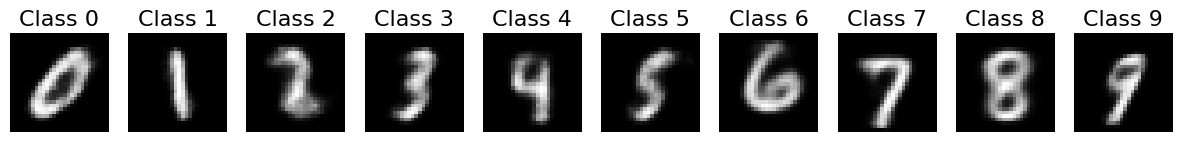


##################################################
CVAE-MLP Epoch [2/10], Loss: 138.99427174479166
Sample Images:


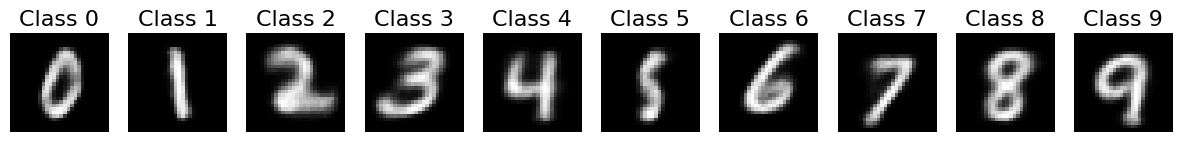


##################################################
CVAE-MLP Epoch [3/10], Loss: 135.46474662272135
Sample Images:


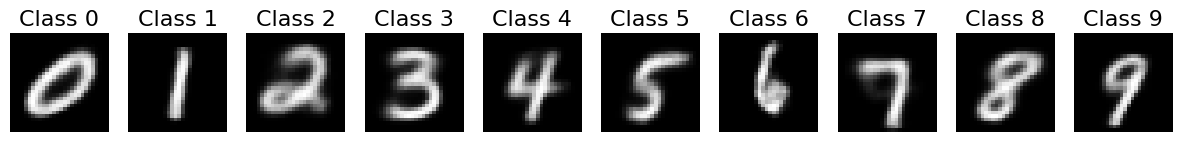


##################################################
CVAE-MLP Epoch [4/10], Loss: 133.7201572998047
Sample Images:


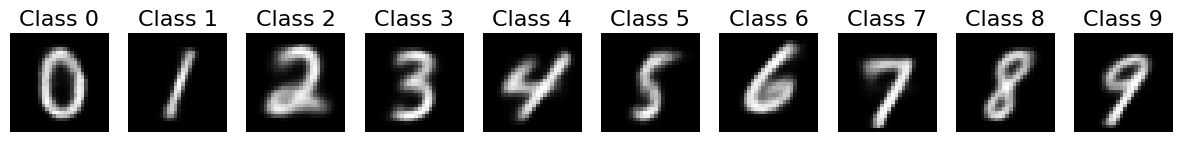


##################################################
CVAE-MLP Epoch [5/10], Loss: 132.5692560831706
Sample Images:


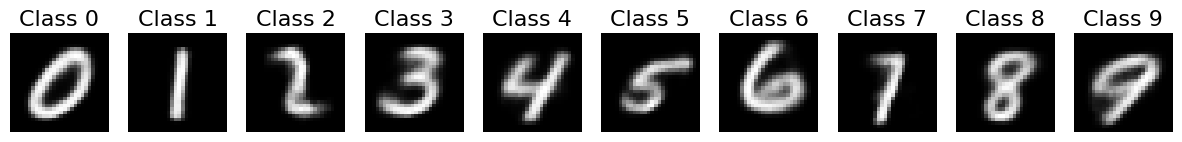


##################################################
CVAE-MLP Epoch [6/10], Loss: 131.77245099283854
Sample Images:


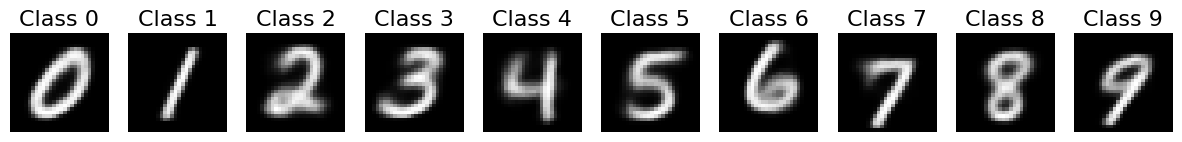


##################################################
CVAE-MLP Epoch [7/10], Loss: 131.20462377115885
Sample Images:


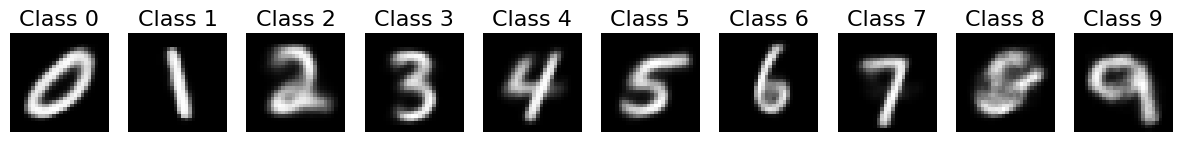


##################################################
CVAE-MLP Epoch [8/10], Loss: 130.72979883626303
Sample Images:


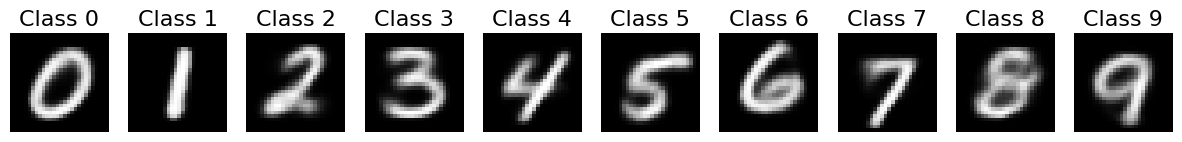


##################################################
CVAE-MLP Epoch [9/10], Loss: 130.26195814615886
Sample Images:


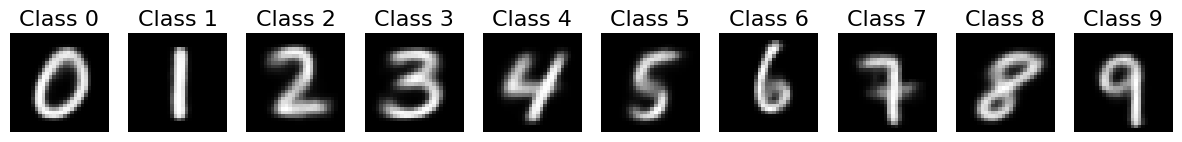


##################################################
CVAE-MLP Epoch [10/10], Loss: 129.92399883626302
Sample Images:


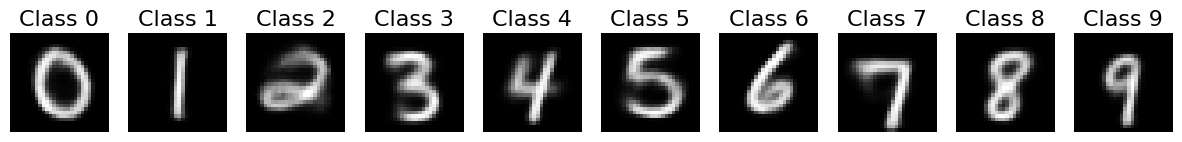

Best model saved as 'best_cvae_mlp_model.pth'


In [13]:
input_dim = 28*28  # Input dimension
hidden_dim = 256  # Hidden dimension
latent_dim = 2  # Latent dimension
num_classes = 10  # Number of classes
cvae_mlp = CVAE_MLP(input_dim, hidden_dim, latent_dim, num_classes)
train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


In [21]:
from tqdm import tqdm
import pandas as pd
import seaborn as sns
vae_mlp.eval()

# Generate some random data points to pass through the decoder
num_samples = 1000
# z_samples = torch.randn(num_samples, 2)

# Pass the z_samples through the decoder to get the reconstructed output
z_samples = np.zeros((len(train_loader.dataset),3))
i = 0
for  batch_idx, (data, labels) in tqdm(enumerate(train_loader)):
  data = data.view(data.size(0), -1)
  recon, mu, logvar, z_batch = vae_mlp(data)
  for z,lab in zip(z_batch,labels):
    z_samples[i,:2] = z.detach().numpy()
    z_samples[i,2] = lab
    i+=1

938it [00:11, 82.87it/s] 


plot using histogram

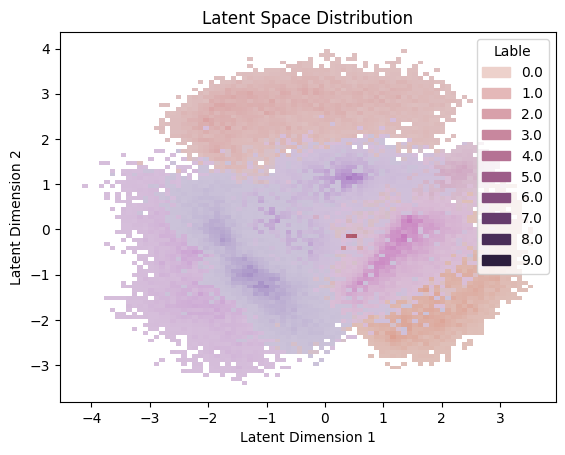

In [25]:
# Visualize the latent space distribution
df = pd.DataFrame(z_samples, columns=['Latent Dimension 1', 'Latent Dimension 2', 'Lable'])
sns.histplot(df,x="Latent Dimension 1", y="Latent Dimension 2", hue="Lable").set_title('Latent Space Distribution');

using kde plot

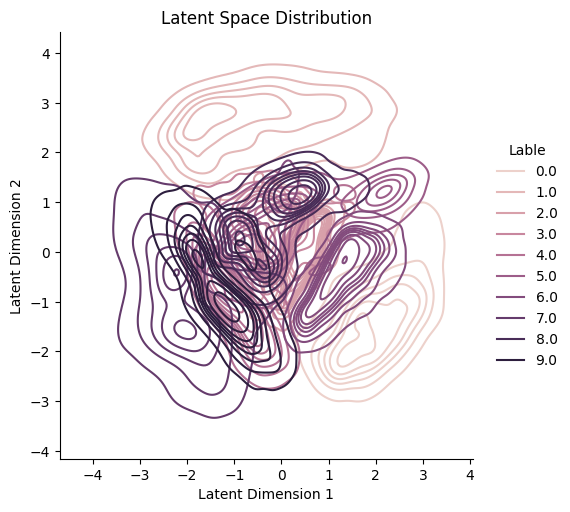

In [27]:
sns.displot(df,x="Latent Dimension 1", y="Latent Dimension 2", hue="Lable",kind="kde").set(title='Latent Space Distribution')

In [28]:

cvae_mlp.eval()

# Generate some random data points to pass through the decoder

num_classes = 10  # Number of classes (0 to 9)
num_samples_per_class = 100  # One sample per class
z_samples = np.zeros((len(train_loader.dataset),3))
i = 0
for  batch_idx, (data, labels) in tqdm(enumerate(train_loader)):
  num_classes = 10  # Number of classes (0 to 9)
  labels_one_hot = torch.eye(num_classes)[labels]
  recon, mu, logvar,class_logits, z_batch = cvae_mlp(data,labels_one_hot)
  for z,lab in zip(z_batch,labels):
    z_samples[i,:2] = z.detach().numpy()
    z_samples[i,2] = lab
    i+=1
    # x_recon_samples = vae_mlp.decoder(z_samples).numpy()

# Visualize the latent space distribution
# plt.scatter(z_samples[:, 0], z_samples[:, 1], alpha=0.5, label='Latent Space Samples')
# plt.xlabel('Latent Dimension 1')
# plt.ylabel('Latent Dimension 2')
# plt.title('Latent Space Distribution')
# plt.show()


938it [00:11, 83.79it/s] 


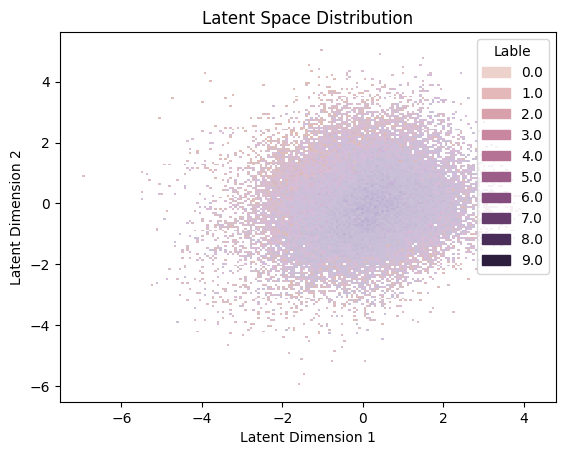

In [29]:
df = pd.DataFrame(z_samples, columns=['Latent Dimension 1', 'Latent Dimension 2', 'Lable'])
sns.histplot(df,x="Latent Dimension 1", y="Latent Dimension 2", hue="Lable").set_title('Latent Space Distribution');

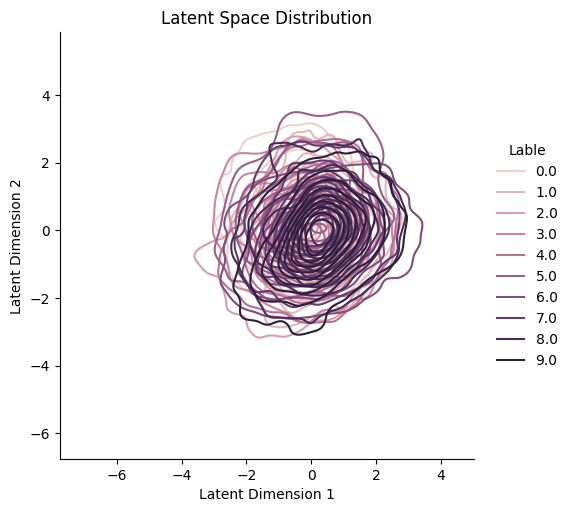

In [30]:
sns.displot(df,x="Latent Dimension 1", y="Latent Dimension 2", hue="Lable",kind="kde").set(title='Latent Space Distribution')

by looking at kde plot of VAE and CVAE we can understand that in VAE each lable is located sepreatly in the latent space and by giving different sample of Z we will get diffrent lables

while in the CVAE the lable is passed directly to the encoder and decoder so there is no need for the model to alocate diffrent location for diffrent lables and this inforamtion is passed directly to the model

another thing to notice is that CVAE is more like guassian while VAE is less like guassian this is because of the fact that we will have to undestand the lables and that is the trade of between the two loss terms in our loss